# TCLab 초기화 (코드 일시 중단 시 사용)

In [2]:
import tclab
a = tclab.TCLab()
a.Q1(0)
a.Q2(0)
a.close()


TCLab version 1.0.0
Arduino Leonardo connected on port /dev/ttyACM0 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.
TCLab disconnected successfully.


# PID 계수 측정을 위한 데이터수집

In [4]:
import numpy as np
import pandas as pd
import tclab
import time
import os.path

# generate step test data on Arduino
filename = 'data.csv'

# redo data collection?
redo = False

# check if file already exists
if os.path.isfile(filename) and (not redo):
    print('File: '+filename+' already exists.')
    print('Change redo=True to collect data again')
    print('TCLab should be at room temperature at start')
else:
    # heater steps
    Q1d = np.zeros(1001)
    Q1d[10:200] = 80
    Q1d[200:280] = 20
    Q1d[280:400] = 70
    Q1d[400:600] = 50
    Q1d[600:680] = 90
    Q1d[680:780] = 0
    Q1d[780:920] = 60
    Q1d[920:] = 40

    Q2d = np.zeros(1001)
    Q2d[120:320] = 100
    Q2d[320:520] = 10
    Q2d[520:620] = 80
    Q2d[620:720] = 20
    Q2d[720:850] = 50
    Q2d[850:940] = 70
    Q2d[940:]=30 

    # Connect to Arduino
    a = tclab.TCLab()
    fid = open(filename,'w')
    fid.write('Time,Q1,Q2,T1,T2\n')
    fid.close()

    # run step test (10 min)
    for i in range(1001):
        # set heater values
        a.Q1(Q1d[i])
        a.Q2(Q2d[i])
        print('Time: ' + str(i) + \
              ' Q1: ' + str(Q1d[i]) + \
              ' Q2: ' + str(Q2d[i]) + \
              ' T1: ' + str(a.T1)   + \
              ' T2: ' + str(a.T2))
        # wait 1 second
        time.sleep(1)
        fid = open(filename,'a')
        fid.write(str(i)+','+str(Q1d[i])+','+str(Q2d[i])+',' \
                  +str(a.T1)+','+str(a.T2)+'\n')
    # close connection to Arduino
    a.close()
    fid.close()

TCLab version 1.0.0
Arduino Leonardo connected on port /dev/ttyACM0 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.
TCLab disconnected successfully.


# FOPDT 파라미터 최적화

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# initial guesses
x0 = np.zeros(4)
x0[0] = 0.8 # Kp
x0[1] = 0.2 # Kd
x0[2] = 150.0 # taup
x0[3] = 10.0 # thetap

# Import CSV data file
# try to read local data file first
try:
    filename = 'data.csv'
    data = pd.read_csv(filename)
except:
    filename = 'http://apmonitor.com/pdc/uploads/Main/tclab_data2.txt'
    data = pd.read_csv(filename)
Q1_0 = data['Q1'].values[0]
Q2_0 = data['Q2'].values[0]
T1_0 = data['T1'].values[0]
T2_0 = data['T2'].values[0]
t = data['Time'].values - data['Time'].values[0]
Q1 = data['Q1'].values
Q2 = data['Q2'].values
T1 = data['T1'].values
T2 = data['T2'].values

# specify number of steps
ns = len(t)
delta_t = t[1]-t[0]
# create linear interpolation of the u data versus time
Qf1 = interp1d(t,Q1)
Qf2 = interp1d(t,Q2)

# define first-order plus dead-time approximation    
def fopdt(T,t,Qf1,Qf2,Kp,Kd,taup,thetap):
    #  T      = states
    #  t      = time
    #  Qf1    = input linear function (for time shift)
    #  Qf2    = input linear function (for time shift)
    #  Kp     = model gain
    #  Kd     = disturbance gain
    #  taup   = model time constant
    #  thetap = model time constant
    # time-shift Q
    try:
        if (t-thetap) <= 0:
            Qm1 = Qf1(0.0)
            Qm2 = Qf2(0.0)
        else:
            Qm1 = Qf1(t-thetap)
            Qm2 = Qf2(t-thetap)
    except:
        Qm1 = Q1_0
        Qm2 = Q2_0
    # calculate derivative
    dT1dt = (-(T[0]-T1_0) + Kp*(Qm1-Q1_0) + Kd*(T[1]-T[0]))/taup
    dT2dt = (-(T[1]-T2_0) + (Kp/2.0)*(Qm2-Q2_0) + Kd*(T[0]-T[1]))/taup
    return [dT1dt,dT2dt]

# simulate FOPDT model
def sim_model(x):
    # input arguments
    Kp,Kd,taup,thetap = x
    # storage for model values
    T1p = np.ones(ns) * T1_0
    T2p = np.ones(ns) * T2_0
    # loop through time steps    
    for i in range(0,ns-1):
        ts = [t[i],t[i+1]]
        T = odeint(fopdt,[T1p[i],T2p[i]],ts,args=(Qf1,Qf2,Kp,Kd,taup,thetap))
        T1p[i+1] = T[-1,0]
        T2p[i+1] = T[-1,1]
    return T1p,T2p

# define objective
def objective(x):
    # simulate model
    T1p,T2p = sim_model(x)
    # return objective
    return sum(np.abs(T1p-T1)+np.abs(T2p-T2))

# show initial objective
print('Initial SSE Objective: ' + str(objective(x0)))
print('Optimizing Values...')

# optimize without parameter constraints
#solution = minimize(objective,x0)

# optimize with bounds on variables
bnds = ((0.4, 1.5), (0.1, 0.5), (50.0, 200.0), (0.0, 30.0))
solution = minimize(objective,x0,bounds=bnds,method='SLSQP')

# show final objective
x = solution.x
iae = objective(x)
Kp,Kd,taup,thetap = x
print('Final SSE Objective: ' + str(objective(x)))
print('Kp: ' + str(Kp))
print('Kd: ' + str(Kd))
print('taup: ' + str(taup))
print('thetap: ' + str(thetap))
# save fopdt.txt file
fid = open('fopdt.txt','w')
fid.write(str(Kp)+'\n')
fid.write(str(Kd)+'\n')
fid.write(str(taup)+'\n')
fid.write(str(thetap)+'\n')
fid.write(str(T1_0)+'\n')
fid.write(str(T2_0)+'\n')
fid.close()

# calculate model with updated parameters
T1p,T2p = sim_model(x)

plt.figure(1,figsize=(15,7))
plt.subplot(2,1,1)
plt.plot(t,T1,'r.',linewidth=2,label='Temperature 1 (meas)')
plt.plot(t,T2,'b.',linewidth=2,label='Temperature 2 (meas)')
plt.plot(t,T1p,'r--',linewidth=2,label='Temperature 1 (pred)')
plt.plot(t,T2p,'b--',linewidth=2,label='Temperature 2 (pred)')
plt.ylabel(r'T $(^oC)$')
plt.text(200,20,'Integral Abs Error: ' + str(np.round(iae,2)))
plt.text(400,35,r'$K_p$: ' + str(np.round(Kp,1)))  
plt.text(400,30,r'$K_d$: ' + str(np.round(Kd,1)))  
plt.text(400,25,r'$\tau_p$: ' + str(np.round(taup,0)) + ' sec')  
plt.text(400,20,r'$\theta_p$: ' + str(np.round(thetap,0)) + ' sec')  
plt.legend(loc=2)
plt.subplot(2,1,2)
plt.plot(t,Q1,'b--',linewidth=2,label=r'Heater 1 ($Q_1$)')
plt.plot(t,Q2,'r:',linewidth=2,label=r'Heater 2 ($Q_2$)')
plt.legend(loc='best')
plt.xlabel('time (sec)')
plt.savefig('fopdt_opt.png')
plt.show()

# FOPDT 파라미터를 통한 PID 계수 구하기기

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ipywidgets as wg
from IPython.display import display

n = 1001 # time points to plot
tf = 1000.0 # final time

# Load TCLab FOPDT
fid = open('fopdt.txt','r')
Kp = float(fid.readline())
Kd = float(fid.readline())
taup = float(fid.readline())
thetap = float(fid.readline())
T1_0 = float(fid.readline())
T2_0 = float(fid.readline())
fid.close()
y0 = [T1_0,T2_0]
Kff = -Kp/Kd

def process(y,t,u1,u2):
    y1,y2 = y
    dy1dt = (1.0/taup) * (-(y1-y0[0]) + Kp * u1 + Kd * (y2-y1))
    dy2dt = (1.0/taup) * (-(y2-y0[1]) + (Kp/2.0) * u2 + Kd * (y1-y2))
    return [dy1dt,dy2dt]

def pidPlot(Kc,tauI,tauD,Kff):
    y0 = [23.0,23.0]
    t = np.linspace(0,tf,n) # create time vector
    P1 = np.zeros(n)         # initialize proportional term
    I1 = np.zeros(n)         # initialize integral term
    D1 = np.zeros(n)         # initialize derivative term
    FF1 = np.zeros(n)        # initialize feedforward term
    e1 = np.zeros(n)         # initialize error
    P2 = np.zeros(n)         # initialize proportional term
    I2 = np.zeros(n)         # initialize integral term
    D2 = np.zeros(n)         # initialize derivative term
    FF2 = np.zeros(n)        # initialize feedforward term
    e2 = np.zeros(n)         # initialize error
    OP1 = np.zeros(n)       # initialize controller output
    OP2 = np.zeros(n)       # initialize disturbance
    PV1 = np.ones(n)*y0[0]  # initialize process variable
    PV2 = np.ones(n)*y0[1]  # initialize process variable
    SP1 = np.ones(n)*y0[0]  # initialize setpoint
    SP2 = np.ones(n)*y0[1]  # initialize setpoint
    SP1[10:] = 60.0         # step up
    SP1[400:] = 40.0         # step up
    SP2[150:] = 50.0        # step down
    SP2[350:] = 35.0        # step down
    Kc1 = Kc
    Kc2 = Kc*2.0
    Kff1 = Kff
    Kff2 = Kff*2.0
    iae = 0.0
    # loop through all time steps
    for i in range(1,n):
        # simulate process for one time step
        ts = [t[i-1],t[i]]         # time interval
        heaters = (OP1[max(0,i-int(thetap))],OP2[max(0,i-int(thetap))])
        y = odeint(process,y0,ts,args=heaters)
        y0 = y[1]                  # record new initial condition
        # calculate new OP with PID
        PV1[i] = y[1][0]              # record T1 PV
        PV2[i] = y[1][1]              # record T2 PV
        iae += np.abs(SP1[i]-PV1[i]) + np.abs(SP2[i]-PV2[i])
        dt = t[i] - t[i-1]         # calculate time step
        
        # PID for loop 1
        e1[i] = SP1[i] - PV1[i]       # calculate error = SP - PV
        P1[i] = Kc1 * e1[i]           # calculate proportional term
        I1[i] = I1[i-1] + (Kc1/tauI) * e1[i] * dt  # calculate integral term
        D1[i] = -Kc * tauD * (PV1[i]-PV1[i-1])/dt # calculate derivative
        FF1[i] = Kff1 * (PV2[i]-PV1[i])
        OP1[i] = P1[i] + I1[i] + D1[i] + FF1[i] # calculate new output
        if OP1[i]>=100:
            OP1[i] = 100.0
            I1[i] = I1[i-1] # reset integral
        if OP1[i]<=0:
            OP1[i] = 0.0
            I1[i] = I1[i-1] # reset integral            

        # PID for loop 2
        e2[i] = SP2[i] - PV2[i]       # calculate error = SP - PV
        P2[i] = Kc2 * e2[i]           # calculate proportional term
        I2[i] = I2[i-1] + (Kc2/tauI) * e2[i] * dt  # calculate integral term
        D2[i] = -Kc2 * tauD * (PV2[i]-PV2[i-1])/dt # calculate derivative
        FF2[i] = Kff2 * (PV1[i]-PV2[i])
        OP2[i] = P2[i] + I2[i] + D2[i] + FF2[i] # calculate new output
        if OP2[i]>=100:
            OP2[i] = 100.0
            I2[i] = I2[i-1] # reset integral
        if OP2[i]<=0:
            OP2[i] = 0.0
            I2[i] = I2[i-1] # reset integral            
            
    # plot PID response
    plt.figure(1,figsize=(15,7))
    plt.subplot(2,2,1)
    plt.plot(t,SP1,'k-',linewidth=2,label='Setpoint 1 (SP)')
    plt.plot(t,PV1,'r:',linewidth=2,label='Temperature 1 (PV)')
    plt.ylabel(r'T $(^oC)$')
    plt.text(100,35,'Integral Abs Error: ' + str(np.round(iae,2)))
    plt.text(400,35,r'$K_{c1}$: ' + str(np.round(Kc,1)))  
    plt.text(400,30,r'$\tau_I$: ' + str(np.round(tauI,0)) + ' sec')  
    plt.text(400,25,r'$\tau_D$: ' + str(np.round(tauD,0)) + ' sec')  
    plt.text(400,20,r'$K_{ff}$: ' + str(np.round(Kff1,2)))  
    plt.ylim([15,70])
    plt.legend(loc=1)
    plt.subplot(2,2,2)
    plt.plot(t,SP2,'k-',linewidth=2,label='Setpoint 2 (SP)')
    plt.plot(t,PV2,'r:',linewidth=2,label='Temperature 2 (PV)')
    plt.ylabel(r'T $(^oC)$')
    plt.text(20,65,r'$K_{c2}$: ' + str(np.round(Kc*2,1)))  
    plt.text(20,60,r'$\tau_I$: ' + str(np.round(tauI,0)) + ' sec')  
    plt.text(20,55,r'$\tau_D$: ' + str(np.round(tauD,0)) + ' sec')  
    plt.text(20,50,r'$K_{ff}$: ' + str(np.round(Kff2,2)))
    plt.ylim([15,70])
    plt.legend(loc=1)
    plt.subplot(2,2,3)
    plt.plot(t,OP1,'b--',linewidth=2,label='Heater 1 (OP)')
    plt.legend(loc='best')
    plt.xlabel('time (sec)')
    plt.subplot(2,2,4)
    plt.plot(t,OP2,'b--',linewidth=2,label='Heater 2 (OP)')
    plt.legend(loc='best')
    plt.xlabel('time (sec)')

print('PID with Feedforward Simulator: Adjust Kc, tauI, tauD, and Kff ' + \
      'to achieve lowest Integral Abs Error')

# ITAE Setpoint Tracking PI Tuning
Kc = (0.586/Kp)*(thetap/taup)**(-0.916); tauI = taup/(1.03-0.165*(thetap/taup))
print(f'ITAE Recommended: Kc={Kc:4.2f}, tauI={tauI:5.1f}, tauD=0, Kff={Kff:4.2f}')

# IMC Aggressive PID Tuning
tauc = max(0.1*taup,0.8*thetap); Kc = (1/Kp)*(taup+0.5*taup)/(tauc+0.5*thetap)
tauI = taup+0.5*thetap; tauD = taup*thetap/(2*taup+thetap); Kff=-Kd/Kp
print(f'IMC Recommended: Kc={Kc:4.2f}, tauI={tauI:5.1f}, tauD={tauD:4.2f}, Kff={Kff:4.2f}')

Kc_slide = wg.FloatSlider(value=Kc,min=0.0,max=50.0,step=1.0)
tauI_slide = wg.FloatSlider(value=tauI,min=20.0,max=250.0,step=1.0)
tauD_slide = wg.FloatSlider(value=tauD,min=0.0,max=20.0,step=1.0)
Kff_slide = wg.FloatSlider(value=Kff,min=-0.5,max=0.5,step=0.1)
wg.interact(pidPlot, Kc=Kc_slide, tauI=tauI_slide, tauD=tauD_slide,Kff=Kff_slide)
print('')

# PID 제어를 통한 강화학습 데이터 수집

- 한 에피소드 당 20분
- 목표온도가 일정 주기마다 변동 됨
- 25~65C 범위의 균등분포에서 목표온도를 추출
- 20분을 2~4 등분하는 정규분포를 이용해 목표온도가 변화하는 주기 생성

In [ ]:
import tclab
import numpy as np
import time
import csv
import matplotlib.pyplot as plt

import os
# PID 상수
Kc   = 9.24
tauI = 126.6 # sec
tauD = 8.90  # sec
Kff  = -0.66
st_temp = 29.0

# 에피소드 루프
EPISODES = 50
DURATION = 1200
sleep_max = 1.0

csv_dir = '../data/PID2MPC/PID3/csv'
png_dir = '../data/PID2MPC/PID3/png'
os.makedirs(csv_dir, exist_ok=True)
os.makedirs(png_dir, exist_ok=True)

def generate_random_tsp(length, name='TSP'):
    i = 0
    tsp = np.zeros(length)
    print(f'duration {length}: [{name} 설정 정보]')
    while i < length:
        if length == 600: 
            duration = int(np.clip(np.random.normal(240, 50), 80, 400))
        elif length == 900:
            duration = int(np.clip(np.random.normal(360, 75), 120, 600))
        elif length == 1200:
            duration = int(np.clip(np.random.normal(480, 100), 160, 800))
        else:
            duration = 5
        temp = np.random.uniform(25, 65)
        end = min(i + duration, length)
        tsp[i:end] = temp
        print(f'  구간: {i:>3} ~ {end - 1:>3}, 목표 온도: {temp:.2f}°C')
        i = end
    return tsp


def pid(sp, pv, pv_last, ierr, dt, d, cid):
    if cid == 1:
        KP = Kc
        Kf = Kff
    else:
        KP = Kc * 2.0
        Kf = Kff * 2.0
    KI = Kc / tauI
    KD = Kc * tauD
    op0 = 0
    ophi = 100
    oplo = 0
    error = sp - pv
    ierr += KI * error * dt
    dpv = (pv - pv_last) / dt
    P = KP * error
    I = ierr
    D = -KD * dpv
    FF = Kf * d
    op = op0 + P + I + D + FF
    if op < oplo or op > ophi:
        I -= KI * error * dt
        op = max(oplo, min(ophi, op))
    return op, P, I, D, FF

def pid_main():
    # 초기화
    a = tclab.TCLab()

    for epi in range(1, EPISODES + 1):

        # 쿨다운
        a.Q1(0)
        a.Q2(0)
        print(f'Check that temperatures are < {st_temp} degC before starting')
        i = 0

        
        while a.T1 >= st_temp or a.T2 >= st_temp:
            print(f'Time: {i} T1: {a.T1} T2: {a.T2}')
            i += 20
            time.sleep(20)

        epi_length = DURATION
        # 랜덤한 구간 및 온도로 setpoint 설정
        Tsp1 = generate_random_tsp(epi_length, 'TSP1')
        Tsp2 = generate_random_tsp(epi_length, 'TSP2')

        tm = np.zeros(epi_length)
        T1 = np.ones(epi_length) * a.T1
        T2 = np.ones(epi_length) * a.T2
        Q1 = np.zeros(epi_length)
        Q2 = np.zeros(epi_length)
        
        print(f'===== Episode {epi} Start =====')
        start_time = time.time()
        prev_time = start_time
        dt_error = 0.0
        # Integral error
        ierr1 = 0.0
        ierr2 = 0.0
        # Integral absolute error
        iae = 0.0

        csv_filename = os.path.join(csv_dir,f'PID_episode_{epi}_data.csv')
        with open(csv_filename, 'w', newline='') as fid:
            writer = csv.writer(fid)
            writer.writerow(['EPI_Num', 'Time', 'Q1', 'Q2', 'T1', 'T2', 'TSP1', 'TSP2'])

            for i in range(1, epi_length):
                sleep = sleep_max - (time.time() - prev_time) - dt_error
                if sleep >= 1e-4:
                    time.sleep(sleep - 1e-4)
                else:
                    print('exceeded max cycle time by ' + str(abs(sleep)) + ' sec')
                    time.sleep(1e-4)

                t = time.time()
                dt = t - prev_time
                if (sleep>=1e-4):
                    dt_error = dt-sleep_max+0.009
                else:
                    dt_error = 0.0
                prev_time = t
                tm[i] = t - start_time
                
                # Read temperatures in Kelvin 
                T1[i] = a.T1
                T2[i] = a.T2

                # Disturbances
                d1 = T1[i] - 23.0
                d2 = T2[i] - 23.0

                # Integral absolute error
                iae += np.abs(Tsp1[i]-T1[i]) + np.abs(Tsp2[i]-T2[i])

                # Calculate PID output
                Q1[i],P,ierr1,D,FF = pid(Tsp1[i],T1[i],T1[i-1],ierr1,dt,d2,1)
                Q2[i],P,ierr2,D,FF = pid(Tsp2[i],T2[i],T2[i-1],ierr2,dt,d1,2)

                # Write output (0-100)
                a.Q1(Q1[i])
                a.Q2(Q2[i])
                
                print("{:>6} {:>6} {:>6} {:>6} {:>6} {:>6} {:>6} {:>6}".format(
                    'Time', 'Tsp1', 'T1', 'Q1', 'Tsp2', 'T2', 'Q2', 'IAE'
                ))
                print(('{:6.1f} {:6.2f} {:6.2f} ' + \
                        '{:6.2f} {:6.2f} {:6.2f} {:6.2f} {:6.2f}').format( \
                            tm[i],Tsp1[i],T1[i],Q1[i],Tsp2[i],T2[i],Q2[i],iae))

                writer.writerow([
                    epi,
                    f"{tm[i]:.2f}",
                    f"{Q1[i]:.2f}",
                    f"{Q2[i]:.2f}",
                    f"{T1[i]:.2f}",
                    f"{T2[i]:.2f}",
                    f"{Tsp1[i]:.2f}",
                    f"{Tsp2[i]:.2f}"
                ])
        # 에피소드 종료 후 그래프 저장
        plt.figure(figsize=(10, 7))
        ax = plt.subplot(2, 1, 1)
        ax.grid()
        plt.plot(tm,Tsp1,'k--',label=r'$T_1$ set point')
        plt.plot(tm,T1,'b.',label=r'$T_1$ measured')
        plt.plot(tm,Tsp2,'k-',label=r'$T_2$ set point')
        plt.plot(tm,T2,'r.',label=r'$T_2$ measured')
        plt.ylabel(r'Temperature ($^oC$)')
        plt.title(f'Episode {epi}')
        plt.legend(loc='best')

        ax = plt.subplot(2, 1, 2)
        ax.grid()
        plt.plot(tm,Q1,'b-',label=r'$Q_1$')
        plt.plot(tm,Q2,'r:',label=r'$Q_2$')
        plt.ylabel('Heater Output (%)')
        plt.xlabel('Time (sec)')
        plt.legend(loc='best')

        plt.tight_layout()
        png_filename=os.path.join(png_dir,f'PID_episode_{epi}_plot.png')
        plt.savefig(png_filename)
        plt.close()

    # 종료
    a.Q1(0)
    a.Q2(0)
    a.close()
    print("All episodes finished.")

pid_main()

TCLab version 1.0.0
Arduino Leonardo connected on port /dev/ttyACM0 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.
Check that temperatures are < 25 degC before starting
Time: 0 T1: 37.334 T2: 33.918


KeyboardInterrupt: 

# 구간 분할을 위한 분포 시각화

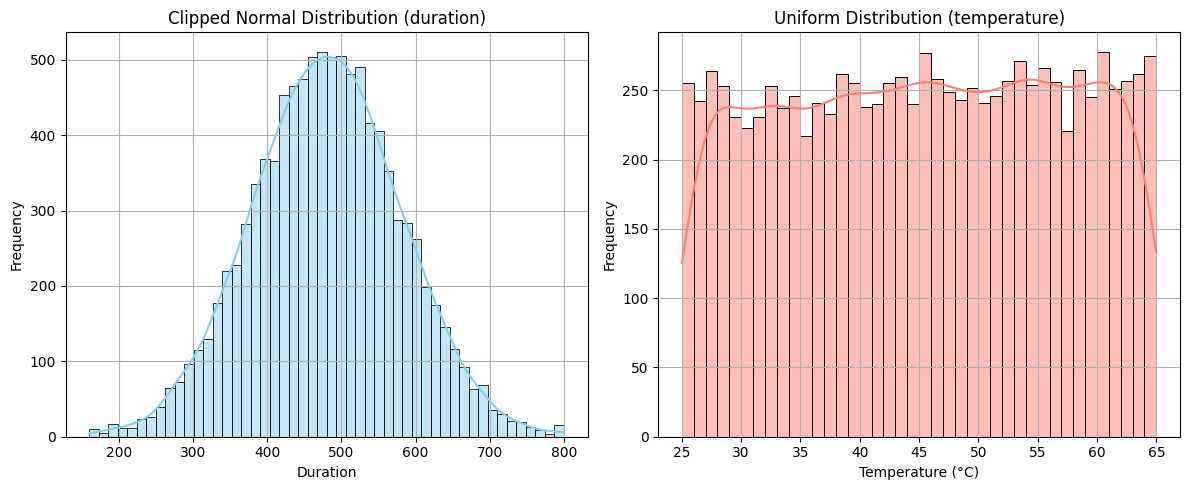

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 시드 고정 (재현 가능)
np.random.seed(42)

# 샘플 수
n = 10000

# 1. 목표온도 변화 주기: 정규분포 → 클리핑
duration_raw = np.random.normal(480, 100, size=n)
duration = np.clip(duration_raw, 160, 800)

# 2. 목표온도도: 균등분포
temp = np.random.uniform(25, 65, size=n)

# 플롯 스타일
plt.figure(figsize=(12, 5))

# duration 그래프
plt.subplot(1, 2, 1)
sns.histplot(duration, kde=True, bins=50, color='skyblue', edgecolor='k')
plt.title('Clipped Normal Distribution (duration)')
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.grid(True)

# temp 그래프
plt.subplot(1, 2, 2)
sns.histplot(temp, kde=True, bins=40, color='salmon', edgecolor='k')
plt.title('Uniform Distribution (temperature)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()
